In [1]:
import numpy as np
import joblib

from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
def average(all_x, all_y):
    ux = np.unique(np.concatenate(all_x))
    uy = np.zeros_like(ux)
    n = len(all_x)
    for x, y in zip(all_x, all_y):
        a = np.interp(ux, x, y)
        uy += a
    uy /= n
    return ux, uy

In [3]:
magnification_factor = '0X'

In [4]:
# Parameters
magnification_factor = "200X"


In [5]:
self_path = os.getcwd()
os.chdir('../../Probas')

In [6]:
paths = glob.glob('*_' + magnification_factor + '_*probas.joblib')
paths

['inception_200X_probas.joblib',
 'vgginnet_200X_3_probas.joblib',
 'vgginnet-ft_200X_4_probas.joblib',
 'vgginnet_200X_4_probas.joblib',
 'vgginnet-ft_200X_2_probas.joblib',
 'vgg_200X_probas.joblib',
 'vgginnet-ft_200X_3_probas.joblib',
 'resnet_200X_probas.joblib',
 'vgginnet-ft_200X_5_probas.joblib',
 'vgginnet_200X_2_probas.joblib',
 'vgginnet_200X_5_probas.joblib',
 'vgginnet_200X_1_probas.joblib',
 'vgginnet-ft_200X_1_probas.joblib']

In [7]:
def clean(name):
    name = name.replace('vgginnet', 'VGGIN-Net')
    name = name.replace('vgg', 'VGG16')
    name = name.replace('inception', 'GoogLeNet')
    name = name.replace('resnet', 'ResNet50')
    name = name.replace('-ft', '_with Fine Tuning')
    name = name.replace('_', ' ')

    name = name.replace(" " + magnification_factor + " ", " ")
    
    name = name.replace(' probas.joblib', '')
    return name

In [8]:
probas = {clean(path): joblib.load(path)['y_probas'] for path in paths}
list(probas.keys())

['GoogLeNet',
 'VGGIN-Net 3',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net 4',
 'VGGIN-Net with Fine Tuning 2',
 'VGG16',
 'VGGIN-Net with Fine Tuning 3',
 'ResNet50',
 'VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net 2',
 'VGGIN-Net 5',
 'VGGIN-Net 1',
 'VGGIN-Net with Fine Tuning 1']

In [9]:
labels = {clean(path): joblib.load(path)['y_test'] for path in paths}
labels = {key: np.argmax(labels[key], axis=-1) for key in labels}
list(labels.keys())

['GoogLeNet',
 'VGGIN-Net 3',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net 4',
 'VGGIN-Net with Fine Tuning 2',
 'VGG16',
 'VGGIN-Net with Fine Tuning 3',
 'ResNet50',
 'VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net 2',
 'VGGIN-Net 5',
 'VGGIN-Net 1',
 'VGGIN-Net with Fine Tuning 1']

In [10]:
n_classes = 2
def process(y_test, y_probas):
    y_test_oh = np.eye(n_classes)[np.int32(y_test)]
    fpr, tpr = [], []
    
    for index in range(n_classes):
        fp, tp, _ = roc_curve(y_test_oh[:, index], y_probas[:, index])
        fpr.append(fp)
        tpr.append(tp)

    f, t = average(fpr, tpr)
    return f, t

In [11]:
sns.set()
sns.set_style('whitegrid')

In [12]:
rocs = {key: process(labels[key], probas[key]) for key in probas.keys()}
rocs

{'GoogLeNet': (array([0.        , 0.00258398, 0.00516796, 0.00632911, 0.00775194,
         0.01033592, 0.01265823, 0.0129199 , 0.01550388, 0.01808786,
         0.01898734, 0.02325581, 0.02583979, 0.02842377, 0.03100775,
         0.03164557, 0.03359173, 0.03797468, 0.03875969, 0.04134367,
         0.04392765, 0.0443038 , 0.04651163, 0.05063291, 0.05167959,
         0.05426357, 0.05696203, 0.0620155 , 0.06329114, 0.06962025,
         0.06976744, 0.07235142, 0.0749354 , 0.07751938, 0.08227848,
         0.08268734, 0.08527132, 0.0878553 , 0.08860759, 0.09043928,
         0.09493671, 0.10126582, 0.10594315, 0.10759494, 0.11111111,
         0.11392405, 0.11886305, 0.12025316, 0.12144703, 0.12658228,
         0.12919897, 0.13291139, 0.13924051, 0.15822785, 0.16455696,
         0.17054264, 0.17312661, 0.17829457, 0.1835443 , 0.19896641,
         0.20253165, 0.20413437, 0.20930233, 0.21518987, 0.22222222,
         0.24031008, 0.25949367, 0.26614987, 0.29113924, 0.29198966,
         0.30379747, 

In [13]:
single_fold = [
    'VGG16',
    'GoogLeNet',
    'ResNet50']

multi_fold = [
    'VGGIN-Net',
    'VGGIN-Net with Fine Tuning']

order = single_fold + multi_fold

In [14]:
curves = {}

for ord in multi_fold:
    fs, ts = [], []
    auc_vals = []
    for i in range(1, 5 + 1):
        name = ord + ' %d' % i
        f, t = rocs[name]
        
        auc_vals.append(auc(f, t))
        fs.append(f)
        ts.append(t)

    curves[ord] = {
        'curve': average(fs, ts),
        'auc_mean': np.mean(auc_vals),
        'auc_std': np.std(auc_vals)
    }

for ord in single_fold:
    f, t = rocs[ord]
    curves[ord] = {
        'curve': (f, t),
        'auc': auc(f, t)
    }

In [15]:
curves

{'VGGIN-Net': {'curve': (array([0.        , 0.00258398, 0.00516796, 0.00775194, 0.01033592,
          0.0129199 , 0.01550388, 0.01808786, 0.02067183, 0.02325581,
          0.02531646, 0.02583979, 0.02842377, 0.03100775, 0.03164557,
          0.03359173, 0.03617571, 0.03875969, 0.0443038 , 0.04909561,
          0.05063291, 0.05167959, 0.05426357, 0.05696203, 0.05943152,
          0.0620155 , 0.06329114, 0.06459948, 0.06718346, 0.06962025,
          0.06976744, 0.07235142, 0.0749354 , 0.07594937, 0.07751938,
          0.08010336, 0.08227848, 0.08268734, 0.0878553 , 0.08860759,
          0.09302326, 0.09493671, 0.09819121, 0.10335917, 0.10759494,
          0.10852713, 0.11111111, 0.11369509, 0.11627907, 0.12144703,
          0.12658228, 0.13178295, 0.13436693, 0.13924051, 0.13953488,
          0.14470284, 0.14556962, 0.14728682, 0.1498708 , 0.15189873,
          0.16455696, 0.17721519, 0.1835443 , 0.19121447, 0.20413437,
          0.20930233, 0.21518987, 0.22151899, 0.2278481 , 0.23417722

In [16]:
os.chdir(self_path)
os.getcwd()

'/home/manisha.saini/vggin-net-github/utils/ROC'

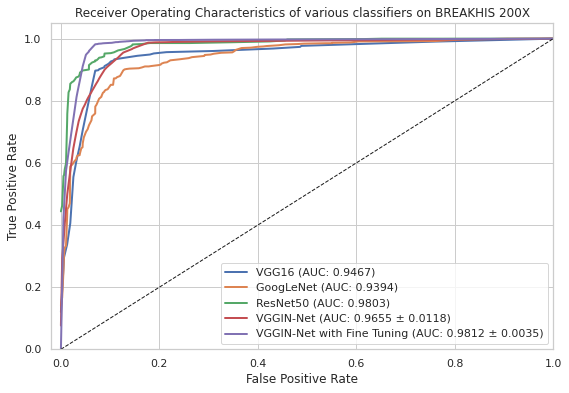

In [17]:
plt.figure(figsize=(9, 6))

lines = []
legends = []

for key in order:
    f, t = curves[key]['curve']
    line, = plt.plot(f, t, lw=2.)
    lines.append(line)

    if 'auc' in curves[key]:
        legends.append('%s (AUC: %0.4f)' % (key, curves[key]['auc']))
    else:
        legends.append('%s (AUC: %0.4f ± %0.4f)' % (key,
                                                    curves[key]['auc_mean'],
                                                    curves[key]['auc_std']))
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(lines, legends)
plt.title('Receiver Operating Characteristics of various classifiers on BREAKHIS ' + magnification_factor)
plt.savefig('ROC' + magnification_factor + '.pdf')
plt.show()